In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
# read in csv as dataframe
county_df = pd.read_csv('https://mydataclassdb-bucket.s3.amazonaws.com/covid_and_politics_db.csv')
county_df.head()

,county,state,county_state,lat,long,totalpop,total_votes20,votes20_donald_trump,votes20_joe_biden,percentage20_donald_trump,...,age_55to64,age_65to74,age_75to84,age_84plus,evangelicals,protestant,catholic,orthodox,muslim,other
0,Kay,OK,"Kay, OK",36.817997,-97.144214,45173,17249,12834,4040,0.744,...,5694,4632,2724,1183,0,0,0,0,0,0
1,Abbeville,SC,"Abbeville, SC",34.223334,-82.461707,24788,12433,8215,4101,0.661,...,3584,3150,1602,591,0,0,0,0,0,0
2,Acadia,LA,"Acadia, LA",30.295065,-92.414197,62607,28425,22596,5443,0.795,...,0,0,0,0,0,0,0,0,0,0
3,Accomack,VA,"Accomack, VA",37.767072,-75.632346,32840,16938,9172,7578,0.542,...,5270,4451,2301,886,0,0,0,0,0,0
4,Ada,ID,"Ada, ID",43.452658,-116.241552,435117,259389,130699,120539,0.504,...,56615,42027,18576,7189,0,0,0,0,0,0


<BarContainer object of 3048 artists>

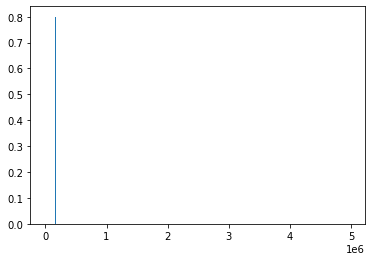

In [11]:
plt.bar(county_df.men,height=.8)

In [12]:
print(county_df['men'].min())
print(county_df['men'].max())

39
4979641


<AxesSubplot:>

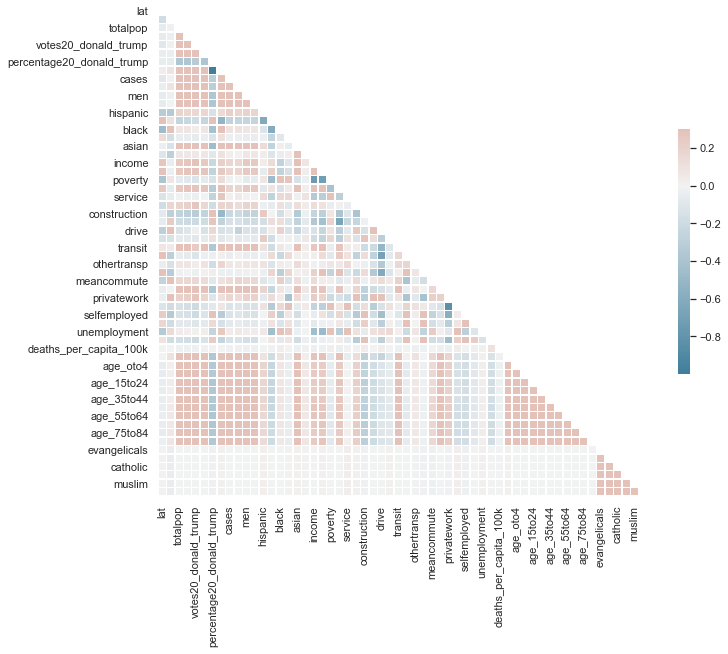

In [13]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = county_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
data = county_df['men']
binwidth = 100
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))

In [14]:
print(county_df['men'].min())
print(county_df['men'].max())

39
4979641


Text(0.5, 0, 'cases per county')

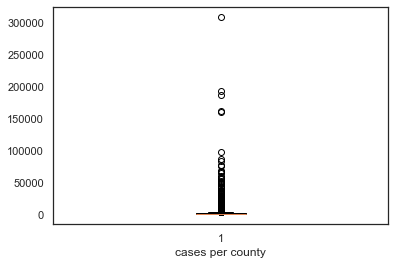

In [21]:
plt.boxplot(county_df['normalized_cases'])
plt.xlabel('cases per county')


In [39]:
X = county_df['percentage20_donald_trump'].values.reshape(-1,1)
X[:5]

array([[0.744],
       [0.661],
       [0.795],
       [0.542],
       [0.504]])

In [40]:
county_df['normalized_cases'] = county_df['cases']/county_df['totalpop']
county_df['normalized_cases']

0       0.020366
1       0.032475
2       0.050825
3       0.037363
4       0.040106
          ...   
3043    0.037071
3044    0.031420
3045    0.050655
3046    0.041854
3047    0.024638
Name: normalized_cases, Length: 3048, dtype: float64

Text(0.5, 0, 'covid cases per county')

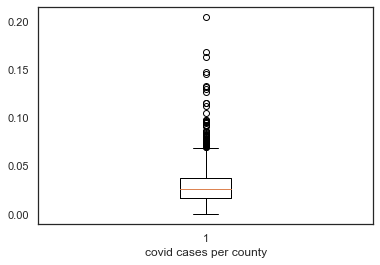

In [41]:
#my_plot = 
plt.boxplot(county_df['normalized_cases'])
plt.xlabel('covid cases per county')

In [42]:
y = county_df['normalized_cases']
y[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [43]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              6517.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                        0.00
Time:                        21:30:30   Log-Likelihood:                          7763.5
No. Observations:                3048   AIC:                                 -1.552e+04
Df Residuals:                    3047   BIC:                                 -1.552e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [44]:
print('Parameters: ', results.params)
print('Standard errors: ', results.bse)
print('Predicted values: ', results.predict())

Parameters:  x1    0.041065
dtype: float64
Standard errors:  x1    0.000509
dtype: float64
Predicted values:  [0.03055199 0.02714364 0.03264628 ... 0.03014135 0.03469951 0.03646528]


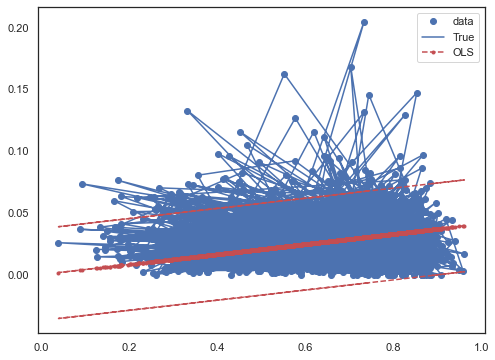

In [45]:
prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, 'o', label="data")
ax.plot(X, y, 'b-', label="True")
ax.plot(X, results.fittedvalues, 'r--.', label="OLS")
ax.plot(X, iv_u, 'r--')
ax.plot(X, iv_l, 'r--')
ax.legend(loc='best');

In [49]:
X2 = county_df['percentage20_joe_biden'].values.reshape(-1,1)
X2[:5]

array([[0.234],
       [0.33 ],
       [0.191],
       [0.447],
       [0.465]])

In [50]:
y2 = county_df.normalized_cases
y2[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [51]:
model = sm.OLS(y2, X2)
results2 = model.fit()
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                              4626.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                        0.00
Time:                        21:34:50   Log-Likelihood:                          7427.7
No. Observations:                3048   AIC:                                 -1.485e+04
Df Residuals:                    3047   BIC:                                 -1.485e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

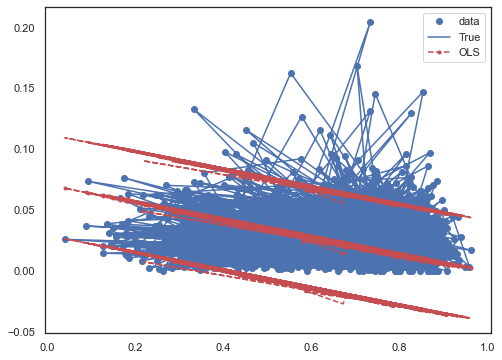

In [52]:
prstd, iv_l, iv_u = wls_prediction_std(results2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, 'o', label="data")
ax.plot(X, y, 'b-', label="True")
ax.plot(X, results2.fittedvalues, 'r--.', label="OLS")
ax.plot(X, iv_u, 'r--')
ax.plot(X, iv_l, 'r--')
ax.legend(loc='best');